# How to use paramManager
paramManager writes and reads parameter files for data file sets, one structured parameter dictionary per data file.

In [3]:
import numpy as np
import librosa # conda install -c conda-forge librosa
import librosa.display

import os  # for mkdir
from os import listdir
from os.path import isfile, join

%matplotlib inline
import matplotlib.pyplot as plt

##-----------   paramManager  interface   ------------------##
from paramManager import paramManager

In [4]:
datapath='./data'
parampath='./data/dataparams' 
# print the files (but not the directories) in datapath
[f for f in os.listdir(datapath) if os.path.isfile(os.path.join(datapath, f))]

['brass_acoustic_018-076-127.wav',
 'reed_acoustic_000-073-127.wav',
 'brass_acoustic_018-075-127.wav',
 'reed_acoustic_000-071-127.wav',
 'reed_acoustic_000-074-127.wav',
 'reed_acoustic_000-076-127.wav',
 'reed_acoustic_000-077-127.wav',
 'reed_acoustic_000-070-127.wav',
 'brass_acoustic_018-070-127.wav',
 'reed_acoustic_000-072-127.wav',
 'brass_acoustic_018-071-127.wav',
 'reed_acoustic_000-078-127.wav',
 'brass_acoustic_018-072-127.wav',
 'brass_acoustic_018-077-127.wav',
 'brass_acoustic_018-078-127.wav',
 'brass_acoustic_018-079-127.wav',
 'reed_acoustic_000-075-127.wav',
 'brass_acoustic_018-074-127.wav',
 'brass_acoustic_018-073-127.wav',
 'reed_acoustic_000-079-127.wav']

In [5]:
# paramManager, create 
pm=paramManager(datapath, parampath)  ##-----------   paramManager  interface ------------------##

In [6]:
# initialize parameter files for the data (only necessary if they don't already exist)
# The boolean parameter tells whether to overwrite current parameter directory (default is False)
pm.initParamFiles(overwrite=True) ##-----------   paramManager  interface ------------------##

In [7]:
# paramManager , check that data files and paramfiles match in number and name
pm.checkIntegrity() ##-----------   paramManager  interface   ------------------##

True

In [8]:
# param Manager , get the parameter dictionary for a file 
# This is the critical function for getting parameters for training nets. 

##-----------   paramManager  interface   ------------------##
foo=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav') #the path and extension are optional
foo

{'meta': {u'filename': u'reed_acoustic_000-072-127.wav'}}

# First a little essentia demo

In [9]:
# http://essentia.upf.edu/documentation/documentation.html
import essentia # conda install -c thomasfillon essentia
import essentia.standard


In [10]:
testfile = datapath + '/' + 'reed_acoustic_000-072-127.wav'

loader = essentia.standard.AudioLoader(filename=testfile) #Monoloader doesn't get metadata

# and then we actually perform the loading:
(audio, sr,chans,_,_,_) = loader()
print("shape of audio is  is {}".format(audio.shape))
print("chans is {}".format(chans))
print("audio is {}".format(audio))
audio=audio[:,0] #get (the) one (and only) channel

import IPython
IPython.display.Audio(testfile)


shape of audio is  is (64000, 2)
chans is 1
audio is [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


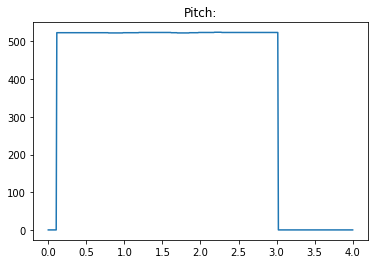

In [11]:
PitchMelodia = essentia.standard.PitchMelodia( binResolution=2, sampleRate=sr, guessUnvoiced=True) # donothing??: , minFrequency=10, maxFrequency=200)
p, pc = PitchMelodia(audio )
pitch_times = np.linspace(0.0,len(audio)/sr,len(p) )
plt.figure()
plt.title("Pitch:")
plt.plot(pitch_times,p)

# paramManager - analyze data files to create a new parameter with Essentia

In [12]:
# Get a list of data file names so we can pass them to essentia for analysis
for fname in pm.getFullPathNames(datapath) :
    print("processing {}".format(fname))
    loader = essentia.standard.AudioLoader(filename=fname) #Monoloader doesn't get metadata
    (audio, sr,chans,_,_,_) = loader()
    audio=audio[:,0] #get (the) one (and only) channel
    
    PitchMelodia = essentia.standard.PitchMelodia( binResolution=2, sampleRate=sr, guessUnvoiced=True) # donothing??: , minFrequency=10, maxFrequency=200)
    p, pc = PitchMelodia(audio )
    
    # Need time points for the parameter file, which essentia does not provide
    pitch_times = np.linspace(0.0,len(audio)/sr,len(p) )
    if (not (len(p) == len(pitch_times))) :
        print("Warning, num parameters not equal to time points")
    
    # Now add the data to the parameter file
    ##-----------   paramManager  interface   ------------------##
    pm.addParam(fname, "pitch", pitch_times, p, units="frequency", nvals=0, minval=0, maxval=1)
    
    

processing ./data/brass_acoustic_018-076-127.wav
processing ./data/reed_acoustic_000-073-127.wav
processing ./data/brass_acoustic_018-075-127.wav
processing ./data/reed_acoustic_000-071-127.wav
processing ./data/reed_acoustic_000-074-127.wav
processing ./data/reed_acoustic_000-076-127.wav
processing ./data/reed_acoustic_000-077-127.wav
processing ./data/reed_acoustic_000-070-127.wav
processing ./data/brass_acoustic_018-070-127.wav
processing ./data/reed_acoustic_000-072-127.wav
processing ./data/brass_acoustic_018-071-127.wav
processing ./data/reed_acoustic_000-078-127.wav
processing ./data/brass_acoustic_018-072-127.wav
processing ./data/brass_acoustic_018-077-127.wav
processing ./data/brass_acoustic_018-078-127.wav
processing ./data/brass_acoustic_018-079-127.wav
processing ./data/reed_acoustic_000-075-127.wav
processing ./data/brass_acoustic_018-074-127.wav
processing ./data/brass_acoustic_018-073-127.wav
processing ./data/reed_acoustic_000-079-127.wav


In [13]:
len(audio)/sr

4.0

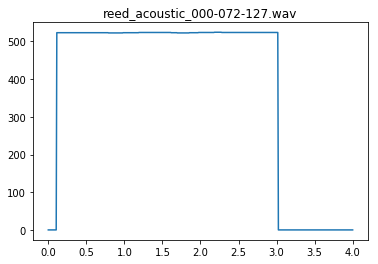

In [14]:
# Here we show how to get a particular parameater from the pdict for a datafile
##-----------   paramManager  interface   ------------------##
fooparams=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav')
foopitch=fooparams['pitch']

#now just show that it looks the same as the essential data 
title=fooparams['meta']['filename']
plt.figure()
plt.title(title)
plt.plot(foopitch['times'], foopitch['values'])

# Librosa demo

('duration=', 4)


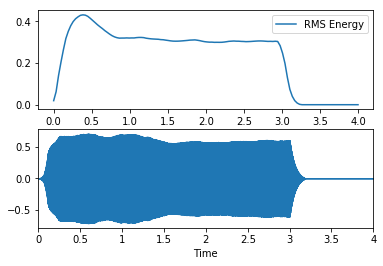

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

sig,sr=librosa.core.load(datapath + "/" + "reed_acoustic_000-072-127.wav", sr=None)
rmse=librosa.feature.rmse(y=sig)[0]
rmse_times = np.linspace(0.0,len(sig)/sr, len(rmse) )

plt.figure()
plt.subplot(2, 1, 1)
#plt.semilogy(rmse.T, label='RMS Energy')
plt.plot(rmse_times, rmse, label='RMS Energy')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
librosa.display.waveplot(sig, sr=16000)

print('duration=',len(sig)/sr)

In [16]:
datafiles = [fname for fname in pm.getFullPathNames(datapath)]
#check all durations are the same
def check_duration(filelist):
    """use librosa's get_duration method to find the duration of all files in filelist"""
    filedurations = [librosa.core.get_duration(filename=f) for f in filelist]
    assert filedurations.count(filedurations[0]) == len(filedurations), "File durations are not all the same!"
    return filedurations[0]

duration = check_duration(datafiles) 
print(duration)

4.0


# paramManager - analyze data files to create a new parameter with LibRosa 

In [17]:
# Get a list of data file names so we can pass them to essentia for analysis
for fname in pm.getFullPathNames(datapath) :
    print("processing {}".format(fname))

    sig,sr=librosa.core.load(fname, sr=None)
    rmse=librosa.feature.rmse(y=sig)[0]
    rmse_times = np.linspace(0.0,len(sig)/sr, len(rmse) )
    
    # Now add the data to the parameter file
    ##-----------   paramManager  interface   ------------------##
    pm.addParam(fname, "rmse", rmse_times, rmse, units="energy", nvals=0, minval=0, maxval=None)
    

processing ./data/brass_acoustic_018-076-127.wav
processing ./data/reed_acoustic_000-073-127.wav
processing ./data/brass_acoustic_018-075-127.wav
processing ./data/reed_acoustic_000-071-127.wav
processing ./data/reed_acoustic_000-074-127.wav
processing ./data/reed_acoustic_000-076-127.wav
processing ./data/reed_acoustic_000-077-127.wav
processing ./data/reed_acoustic_000-070-127.wav
processing ./data/brass_acoustic_018-070-127.wav
processing ./data/reed_acoustic_000-072-127.wav
processing ./data/brass_acoustic_018-071-127.wav
processing ./data/reed_acoustic_000-078-127.wav
processing ./data/brass_acoustic_018-072-127.wav
processing ./data/brass_acoustic_018-077-127.wav
processing ./data/brass_acoustic_018-078-127.wav
processing ./data/brass_acoustic_018-079-127.wav
processing ./data/reed_acoustic_000-075-127.wav
processing ./data/brass_acoustic_018-074-127.wav
processing ./data/brass_acoustic_018-073-127.wav
processing ./data/reed_acoustic_000-079-127.wav


# paramManager, add params from info stored in filenames

In [18]:
import re

for fname in pm.getFullPathNames(datapath) :
    print("processing {}".format(fname))
    
    # first, instrument ID
    if fname.find("brass") >=0 : 
        instID=0
    else : 
        instID=1
    print("    {} is in category {}".format(fname, 1))
            
    ##-----------   paramManager  interface   ------------------##
    pm.addParam(fname, "instID", [0.0,duration], [instID,instID], units="category", nvals=2, minval=0, maxval=1)
    

    #now midiPitch
    n=re.findall(r'(?<=-).*?(?=-)', fname)[0] #3-digit pitch number wedged between dashes (-) in name
    if (n[0]=='0') :
        midinum=int(n[1:])
    else :
        midinum=int(n)
    print("    midi number is {}".format(midinum))
    
    ##-----------   paramManager  interface   ------------------##
    pm.addParam(fname, "midiPitch", [0.0,duration], [midinum,midinum], units="midiPitch", nvals=128, minval=0, maxval=127)
    

processing ./data/brass_acoustic_018-076-127.wav
    ./data/brass_acoustic_018-076-127.wav is in category 1
    midi number is 76
processing ./data/reed_acoustic_000-073-127.wav
    ./data/reed_acoustic_000-073-127.wav is in category 1
    midi number is 73
processing ./data/brass_acoustic_018-075-127.wav
    ./data/brass_acoustic_018-075-127.wav is in category 1
    midi number is 75
processing ./data/reed_acoustic_000-071-127.wav
    ./data/reed_acoustic_000-071-127.wav is in category 1
    midi number is 71
processing ./data/reed_acoustic_000-074-127.wav
    ./data/reed_acoustic_000-074-127.wav is in category 1
    midi number is 74
processing ./data/reed_acoustic_000-076-127.wav
    ./data/reed_acoustic_000-076-127.wav is in category 1
    midi number is 76
processing ./data/reed_acoustic_000-077-127.wav
    ./data/reed_acoustic_000-077-127.wav is in category 1
    midi number is 77
processing ./data/reed_acoustic_000-070-127.wav
    ./data/reed_acoustic_000-070-127.wav is in categ

In [19]:

# Now lets have a look at one of our paramfiles
foo=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav') #the path and extension are optional

### resampling (interpolation) demo

In [20]:
#sometimes we need parameter values at a different sampling rate
#for example we have a section of data made up of 6 samples, taken from 0.0s to 0.03s of reed_acoustic_000-072-127.wav
#but there are only 2 rmse (parameter) values associated with this duration
#to get a rmse (parameter) for each of our 6 samples, load the parameter file using getParams then pass it to resampleParam as follows:

pm.resampleParam(foo,"rmse",6,0.0,0.03,verbose=True)

#this function uses scipy's linear interpolation method

--Data resampled from--
('times:', [0.0, 0.032, 0.064, 0.096, 0.128, 0.16, 0.192, 0.224, 0.256, 0.28800000000000003, 0.32, 0.352, 0.384, 0.41600000000000004, 0.448, 0.48, 0.512, 0.544, 0.5760000000000001, 0.608, 0.64, 0.672, 0.704, 0.736, 0.768, 0.8, 0.8320000000000001, 0.864, 0.896, 0.928, 0.96, 0.992, 1.024, 1.056, 1.088, 1.12, 1.1520000000000001, 1.184, 1.216, 1.248, 1.28, 1.312, 1.344, 1.3760000000000001, 1.408, 1.44, 1.472, 1.504, 1.536, 1.568, 1.6, 1.6320000000000001, 1.6640000000000001, 1.696, 1.728, 1.76, 1.792, 1.824, 1.856, 1.8880000000000001, 1.92, 1.952, 1.984, 2.016, 2.048, 2.08, 2.112, 2.144, 2.176, 2.208, 2.24, 2.2720000000000002, 2.3040000000000003, 2.336, 2.368, 2.4, 2.432, 2.464, 2.496, 2.528, 2.56, 2.592, 2.624, 2.656, 2.688, 2.72, 2.7520000000000002, 2.7840000000000003, 2.816, 2.848, 2.88, 2.912, 2.944, 2.976, 3.008, 3.04, 3.072, 3.104, 3.136, 3.168, 3.2, 3.232, 3.2640000000000002, 3.2960000000000003, 3.3280000000000003, 3.36, 3.392, 3.424, 3.456, 3.488, 3.52, 3.552

(array([0.   , 0.006, 0.012, 0.018, 0.024, 0.03 ]),
 array([0.01929549, 0.02732859, 0.03536169, 0.04339479, 0.05142789,
        0.05946099]))

In [21]:
#the default behaviour of resampleParam is not to overwrite the original param file

foo=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav')
foo

{u'instID': {u'maxval': 1,
  u'minval': 0,
  u'nvals': 2,
  u'times': [0.0, 4.0],
  u'units': u'category',
  u'values': [1, 1]},
 'meta': {u'filename': u'reed_acoustic_000-072-127.wav'},
 u'midiPitch': {u'maxval': 127,
  u'minval': 0,
  u'nvals': 128,
  u'times': [0.0, 4.0],
  u'units': u'midiPitch',
  u'values': [72, 72]},
 u'pitch': {u'maxval': 1,
  u'minval': 0,
  u'nvals': 0,
  u'times': [0.0,
   0.008,
   0.016,
   0.024,
   0.032,
   0.04,
   0.048,
   0.056,
   0.064,
   0.07200000000000001,
   0.08,
   0.088,
   0.096,
   0.10400000000000001,
   0.112,
   0.12,
   0.128,
   0.136,
   0.14400000000000002,
   0.152,
   0.16,
   0.168,
   0.176,
   0.184,
   0.192,
   0.2,
   0.20800000000000002,
   0.216,
   0.224,
   0.232,
   0.24,
   0.248,
   0.256,
   0.264,
   0.272,
   0.28,
   0.28800000000000003,
   0.296,
   0.304,
   0.312,
   0.32,
   0.328,
   0.336,
   0.34400000000000003,
   0.352,
   0.36,
   0.368,
   0.376,
   0.384,
   0.392,
   0.4,
   0.40800000000000003,
   

In [22]:
#but this can be changed if overwrite=True

pm.resampleParam(foo, "rmse",10,0.15,0.25,verbose=True,overwrite=True)
foo=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav')
foo

--Data resampled from--
('times:', [0.0, 0.032, 0.064, 0.096, 0.128, 0.16, 0.192, 0.224, 0.256, 0.28800000000000003, 0.32, 0.352, 0.384, 0.41600000000000004, 0.448, 0.48, 0.512, 0.544, 0.5760000000000001, 0.608, 0.64, 0.672, 0.704, 0.736, 0.768, 0.8, 0.8320000000000001, 0.864, 0.896, 0.928, 0.96, 0.992, 1.024, 1.056, 1.088, 1.12, 1.1520000000000001, 1.184, 1.216, 1.248, 1.28, 1.312, 1.344, 1.3760000000000001, 1.408, 1.44, 1.472, 1.504, 1.536, 1.568, 1.6, 1.6320000000000001, 1.6640000000000001, 1.696, 1.728, 1.76, 1.792, 1.824, 1.856, 1.8880000000000001, 1.92, 1.952, 1.984, 2.016, 2.048, 2.08, 2.112, 2.144, 2.176, 2.208, 2.24, 2.2720000000000002, 2.3040000000000003, 2.336, 2.368, 2.4, 2.432, 2.464, 2.496, 2.528, 2.56, 2.592, 2.624, 2.656, 2.688, 2.72, 2.7520000000000002, 2.7840000000000003, 2.816, 2.848, 2.88, 2.912, 2.944, 2.976, 3.008, 3.04, 3.072, 3.104, 3.136, 3.168, 3.2, 3.232, 3.2640000000000002, 3.2960000000000003, 3.3280000000000003, 3.36, 3.392, 3.424, 3.456, 3.488, 3.52, 3.552

{u'instID': {u'maxval': 1,
  u'minval': 0,
  u'nvals': 2,
  u'times': [0.0, 4.0],
  u'units': u'category',
  u'values': [1, 1]},
 'meta': {u'filename': u'reed_acoustic_000-072-127.wav'},
 u'midiPitch': {u'maxval': 127,
  u'minval': 0,
  u'nvals': 128,
  u'times': [0.0, 4.0],
  u'units': u'midiPitch',
  u'values': [72, 72]},
 u'pitch': {u'maxval': 1,
  u'minval': 0,
  u'nvals': 0,
  u'times': [0.0,
   0.008,
   0.016,
   0.024,
   0.032,
   0.04,
   0.048,
   0.056,
   0.064,
   0.07200000000000001,
   0.08,
   0.088,
   0.096,
   0.10400000000000001,
   0.112,
   0.12,
   0.128,
   0.136,
   0.14400000000000002,
   0.152,
   0.16,
   0.168,
   0.176,
   0.184,
   0.192,
   0.2,
   0.20800000000000002,
   0.216,
   0.224,
   0.232,
   0.24,
   0.248,
   0.256,
   0.264,
   0.272,
   0.28,
   0.28800000000000003,
   0.296,
   0.304,
   0.312,
   0.32,
   0.328,
   0.336,
   0.34400000000000003,
   0.352,
   0.36,
   0.368,
   0.376,
   0.384,
   0.392,
   0.4,
   0.40800000000000003,
   

In [23]:
#instead of resampling 1 parameter at a time, use resampleAllParams to automatically interpolate all of them (will ignore meta)

paramdict = pm.resampleAllParams(foo,5,1.1,1.2,verbose=True)

instID
--Data resampled from--
('times:', [0.0, 4.0])
('values:', [1, 1])
--to--
('times:', array([1.1  , 1.125, 1.15 , 1.175, 1.2  ]))
('values:', array([1., 1., 1., 1., 1.]))
 
rmse
--Data resampled from--
('times:', [0.15, 0.1611111111111111, 0.17222222222222222, 0.18333333333333332, 0.19444444444444445, 0.20555555555555555, 0.21666666666666667, 0.22777777777777777, 0.23888888888888887, 0.25])
('values:', [0.3000255599617958, 0.31794319632980556, 0.32997509754366344, 0.3420069987575213, 0.35343955063985455, 0.3627471367104186, 0.37205472278098267, 0.3805462639364931, 0.38745371790395844, 0.3943611718714237])
--to--
('times:', array([1.1  , 1.125, 1.15 , 1.175, 1.2  ]))
('values:', array([0.9227814 , 0.93832317, 0.95386494, 0.96940671, 0.98494849]))
 
midiPitch
--Data resampled from--
('times:', [0.0, 4.0])
('values:', [72, 72])
--to--
('times:', array([1.1  , 1.125, 1.15 , 1.175, 1.2  ]))
('values:', array([72., 72., 72., 72., 72.]))
 
pitch
--Data resampled from--
('times:', [0.0, 

In [24]:
#we can even select which parameters to resample using the prop variable 
paramdict = pm.resampleAllParams(foo,5,1.1,1.2,prop=['instID','midiPitch'],verbose=True)

instID
--Data resampled from--
('times:', [0.0, 4.0])
('values:', [1, 1])
--to--
('times:', array([1.1  , 1.125, 1.15 , 1.175, 1.2  ]))
('values:', array([1., 1., 1., 1., 1.]))
 
midiPitch
--Data resampled from--
('times:', [0.0, 4.0])
('values:', [72, 72])
--to--
('times:', array([1.1  , 1.125, 1.15 , 1.175, 1.2  ]))
('values:', array([72., 72., 72., 72., 72.]))
 
